In [52]:
!zip -qr mywork.zip /home/aistudio/work

In [ ]:
# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# !unzip -d /home/aistudio/work work/training_set.zip
# !unzip -d /home/aistudio/work work/test_set.zip
# !ls /home/aistudio/work

In [53]:
!unzip mywork.zip -d work/

##                                                                                              	项目目的和背景
超声图像中胎儿头围是评估胎儿发育（评估胎儿体重的重要参数之一）的重要指标，胎儿头围一般由医生手动进行椭圆拟合，费时费力，且存在较高的用户差异，导致胎儿发育诊断的偏差，特别是会导致分娩方式决定的错误。因此基于人工智能算法帮助医生快速检测和评估胎儿头围，可以在短时间内基于算法结果，协助医生选择何种治疗或者分娩方式具有重要的意义。


In [2]:
# #如果github下载网络较差，用户可选择gitee进行下载
!git clone https://gitee.com/paddlepaddle/PaddleSeg.git

Cloning into 'PaddleSeg'...
remote: Enumerating objects: 16439, done.
remote: Counting objects: 100% (1402/1402), done.
remote: Compressing objects: 100% (811/811), done.
remote: Total 16439 (delta 711), reused 1165 (delta 573), pack-reused 15037
Receiving objects: 100% (16439/16439), 341.09 MiB | 9.24 MiB/s, done.
Resolving deltas: 100% (10575/10575), done.
Checking connectivity... done.


In [ ]:
!pip install paddleseg
!pip install scikit-image
!pip install opencv-python==3.4.2.17 -i https://pypi.douban.com/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.4/275.4 KB 3.2 MB/s eta 0:00:00a 0:00:01
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━ 6.5/13.5 MB 969.7 kB/s eta 0:00:08

In [ ]:
# 同时添加如下代码, 这样每次环境(kernel)启动的时候只要运行下方代码即可: 
# Also add the following code, 
# so that every time the environment (kernel) starts, 
# just run the following code: 
import sys 
sys.path.append('/home/aistudio/external-libraries')

## 1.读取文件更改文件名
* 将HC和annotation分离

In [ ]:
###将HC和annotation分离
import os
from glob import glob
src_path = '/home/aistudio/work/training_set'
dst_path = '/home/aistudio/work/train/label'
if os.path.exists('/home/aistudio/work/train/label'):
    print('文件夹已存在')
else:
    os.makedirs('/home/aistudio/work/train/label')
def move_file(src_path, dst_path, file):
    print('from:',src_path)
    print('to:',dst_path)
    try:
        cmd = 'chmod -R +x ' + src_path
        os.popen(cmd)
        f_src = os.path.join(src_path , "{}".format(file))
        f_dst = os.path.join(dst_path,  "{}".format(file))
        shutil.move(f_src, f_dst)
    except Exception as e:
        print ('move_file ERROR: ',e)
        traceback.print_exc()

for i in glob('/home/aistudio/work/training_set/*Annotation.png'):
    file = i.split('/')[-1]
    move_file(src_path, dst_path, file)

文件夹已存在


In [ ]:
!mv work/training_set work/train

In [ ]:
from PIL import Image 
import os
from tqdm import tqdm

img_path='/home/aistudio/work/train/training_set'
save_img_path='/home/aistudio/work/train/rename_img'
label_path='/home/aistudio/work/train/label'
save_label_path='/home/aistudio/work/train/rename_label'
if not os.path.exists(save_img_path):  # 文件夹不存在，则创建
    os.mkdir(save_img_path)

if not os.path.exists(save_label_path):  # 文件夹不存在，则创建
    os.mkdir(save_label_path)

img_list = os.listdir(img_path) #  *****.png f返回的是一个列表
for i in tqdm(range(len(img_list))):
    # print('i='+str(i))

    img_full_path = os.path.join(img_path, img_list[i])
    #label_full_path = os.path.join(label_path, img_list[i][0:-4]+'_Annotation.png')
    label_full_path = os.path.join(label_path, img_list[i].split('.png')[0] + '_Annotation.png')

    img=Image.open(img_full_path) # 不能有中文目录
    img=img.resize((800,540), Image.NEAREST )
    label = Image.open(label_full_path)  # 不能有中文目录
    label = label.resize((800, 540), Image.NEAREST )

    img.save(os.path.join(save_img_path , img_list[i][0:5] + '.png'))
    label.save(os.path.join(save_label_path , img_list[i][0:5] + '.png'))


100%|██████████| 999/999 [01:18<00:00, 12.68it/s]


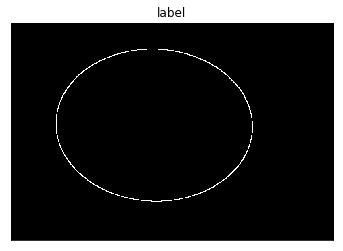

In [ ]:
import cv2
import matplotlib.pyplot as plt
###显示图像前处理之前的label
img = cv2.imread("work/train/rename_label/784_H.png") # 读取的图片路径
# 转换为灰度图
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray,'gray'), plt.title('label'),plt.xticks([]),plt.yticks([])
plt.show()

## 2.生成用于训练和测试的列表

In [ ]:
#导入常用库
from PIL import Image
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle
import cv2
import paddle

In [ ]:
#生成训练测试列表
random.seed(2021)
path_origin = '/home/aistudio/work/train/rename_img'
path_label = '/home/aistudio/work/train/rename_label'
files = list(filter(lambda x: x.endswith('.png'), os.listdir(path_origin)))
random.shuffle(files)
rate = int(len(files) * 0.8)#训练集和测试集8：2
train_txt = open('/home/aistudio/work/train/train_list.txt','w')
val_txt = open('/home/aistudio/work/train/val_list.txt','w')
test_txt = open('/home/aistudio/work/train/test_list.txt','w')
for i,f in enumerate(files):
    image_path = os.path.join(path_origin, f)
    label_name = f.split('.')[0]+ '.png'
    label_path = os.path.join(path_label, label_name)
    if i < rate:
        train_txt.write(image_path + ' ' + label_path+ '\n')
    else:
        val_txt.write(image_path + ' ' + label_path+ '\n') 
train_txt.close()
val_txt.close()
print('完成')

完成


In [ ]:
# 生成测试图像列表
import os
test_origin = '/home/aistudio/work/test_set/'
test_dir = os.listdir(test_origin)
f_test = open('/home/aistudio/work/train/test_list.txt', 'w')

for a in range(len(test_dir)):
    f_test.write(test_origin + test_dir[a] + '\n')


f_test.close()

## 3.图像前处理


In [ ]:
import numpy as np
from skimage.feature import canny 
from scipy import ndimage as ndi #轮廓填充用
from skimage.io import imread, imsave
from skimage import morphology
for i in tqdm(glob('/home/aistudio/work/train/rename_label/*.png')):
    img = imread(i) # 读取的图片路径
    edges = canny(img/255.) ##canny 算子提取周围轮廓
    fill_img = ndi.binary_fill_holes(edges)  #轮廓填充
    imsave(i,fill_img)

In [ ]:
import cv2
# from skimage import morphology # 形态学处理（后处理可能会用到）
from glob import glob
from tqdm import tqdm
#循环灰度图片并保存
def grayImg():
    for x in tqdm(glob('/home/aistudio/work/train/rename_label/*.png')):
        # print(x)
        #读取图片
        img = cv2.imread(x)
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        difference = (img_gray.max() - img_gray.min()) // 2
        _, img_binary = cv2.threshold(img_gray, difference, 1, cv2.THRESH_BINARY)
        # print("阈值：", _)
        #保存灰度后的新图片
        cv2.imwrite(x,img_binary)
grayImg()

100%|██████████| 999/999 [00:06<00:00, 155.17it/s]


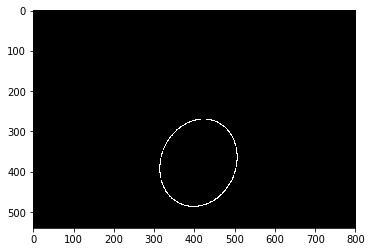

In [ ]:

# 使用opencv读取图像
import cv2
import matplotlib.pyplot as plt
####处理前的标签
img = cv2.imread("work/train/label/000_HC_Annotation.png") # 读取的图片路径
# 转换为灰度图
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray,'gray')
plt.show()
# print(img_gray)

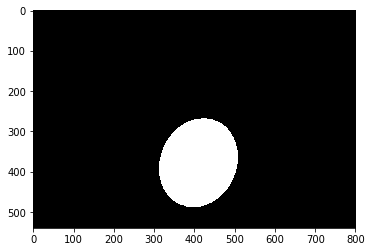

In [ ]:

# 使用opencv读取图像
import cv2
import matplotlib.pyplot as plt
###处理后的标签
img = cv2.imread("work/train/rename_label/000_H.png") # 读取的图片路径
# 转换为灰度图
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray,'gray')
plt.show()
# print(img_gray)

In [ ]:
##创建Transform 和DataSet
import paddleseg.transforms as T
import paddle.vision as V
from paddleseg.datasets import OpticDiscSeg,Dataset

train_transforms = [
    # V.Grayscale(num_output_channels=3), ##转为一个3通道的灰度图
    T.RandomHorizontalFlip(),#水平翻转
    T.RandomDistort(),#随机对比度，颜色等变化
    T.RandomRotation(max_rotation = 10,im_padding_value =(0,0,0),label_padding_value = 0),#随机旋转
    T.RandomBlur(),#随机模糊
    T.RandomScaleAspect(min_scale = 0.8, aspect_ratio = 0.5),#随机缩放
    T.Resize(target_size=(512, 512)),
    T.Normalize()#mean Default: [0.5, 0.5, 0.5]  std Default: [0.5, 0.5, 0.5].
]
val_transforms = [
    T.Resize(target_size=(512, 512)),
    T.Normalize()
]

dataset_root = '/home/aistudio/work/train'
train_path  = '/home/aistudio/work/train/train_list.txt'
val_path  = '/home/aistudio/work/train/val_list.txt'
test_path  = '/home/aistudio/work/train/test_list.txt'
# 构建训练集
train_dataset = Dataset(
    transforms = train_transforms,
                  dataset_root = dataset_root,
                  num_classes = 2,
                  train_path = train_path,
                  mode = 'train'
                  )
#验证集
val_dataset = Dataset(
    transforms = val_transforms,
                  dataset_root = dataset_root,
                  num_classes = 2,
                  val_path = val_path,
                  mode = 'val'
                  )

#测试集
test_dataset = Dataset(
    transforms = val_transforms,
                  dataset_root = dataset_root,
                  num_classes = 2,
                  test_path = test_path,
                  mode = 'test'  #设置为验证模型，方面最后测试模型的效果
                  )

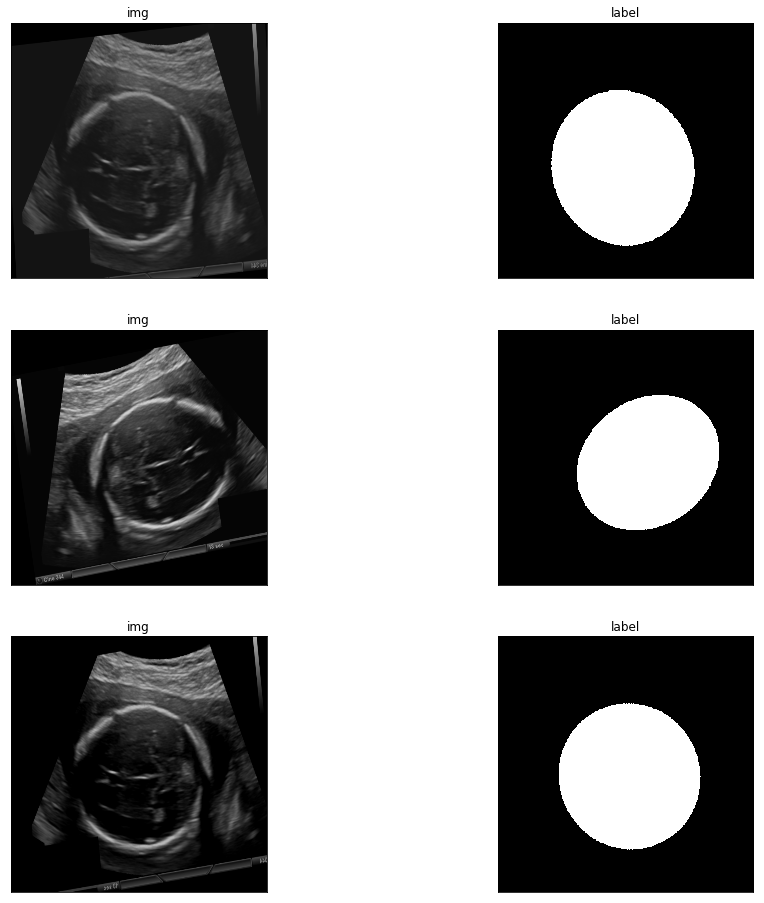

In [ ]:
#显示图像增强后的图片
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(16,16))
for i in range(1,6,2):
    img, label = train_dataset[0]
    img = np.transpose(img, (1,2,0))
    img = img*0.5 + 0.5
    plt.subplot(3,2,i),plt.imshow(img,'gray'),plt.title('img'),plt.xticks([]),plt.yticks([])
    plt.subplot(3,2,i+1),plt.imshow(label,'gray'),plt.title('label'),plt.xticks([]),plt.yticks([])
    plt.show

## 4.设置网络和 损失函数、优化器等

In [1]:

%cd /home/aistudio/PaddleSeg/paddleseg
!python utils/download.py -a AttentionUNet -p ./pretrained -d True   ##下载预训练的模型

[Errno 2] No such file or directory: '/home/aistudio/PaddleSeg/paddleseg'
/home/aistudio
python: can't open file 'utils/download.py': [Errno 2] No such file or directory


In [ ]:
#导入UNet模型
from paddleseg.models import UNet,AttentionUNet
# pretrained = '/home/aistudio/work/model.pdparams'
num_classes = 2
model = AttentionUNet(num_classes=num_classes,pretrained=None)

In [ ]:
from paddleseg.models.losses import CrossEntropyLoss,DiceLoss, MixedLoss
import paddle
# 设置学习率  
base_lr = 0.0015
lr = paddle.optimizer.lr.CosineAnnealingDecay(learning_rate=base_lr, T_max=5400, verbose=False)
optimizer = paddle.optimizer.Momentum(lr, parameters=model.parameters(), momentum=0.9, weight_decay=4.0e-5)
#混合使用CrossEntropyLoss（ ）  和DiceLoss（） 两个损失函数，比单独使用CrossEntropyLoss()好几个点

# losses['types'] = [CrossEntropyLoss()]  #这是单独使用CrossEntropyLoss()
# losses['coef'] = [1]

mixtureLosses = [CrossEntropyLoss(),DiceLoss() ]
mixtureCoef = [0.7,0.3]
losses = {}
losses['types'] = [MixedLoss(mixtureLosses, mixtureCoef)]
losses['coef'] = [1]


## 5.开始训练

In [ ]:
from paddleseg.core import train
#训练集有3617张，
#3617 除以batch_size=4 约等于904， 所有设置save_interval=900
#上面的CosineAnnealingDecay() 的 T_max设置为5400，意思学习率从一开始到经过6个epoch，余弦衰减到0，然后又经过6个
#epoch恢复慢慢到初始值。
train(
    model=model,
    train_dataset=train_dataset,#填写训练集的dataset
    val_dataset=val_dataset,#填写验证集的dataset
    optimizer=optimizer,#优化器
    save_dir='/home/aistudio/Output4',#保存路径
    iters=6100,#训练次数
    batch_size=4,
    save_interval=200,#保存的间隔次数
    log_iters=100,#日志打印间隔
    num_workers=0,
    losses=losses,#传入 
    use_vdl=True
    )#是否使用visualDL

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:641: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance.")
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dygraph/math_op_patch.py:239: UserWarning: The dtype of left and right variables are not the same, left dtype is paddle.float32, but right dtype is paddle.int64, the right dtype will convert to paddle.float32
  format(lhs_dtype, rhs_dtype, lhs_dtype))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dygraph/math_op_patch.py:239: UserWarning: The dtype of left and right variables are not the same, left dtype is paddle.float32, but right dtype is paddle.bool, the right dtype will convert to paddle.float32
  format(lhs_dtype, rhs_dtype, lhs_dtype))


2021-08-03 14:34:01 [INFO]	[TRAIN] epoch: 1, iter: 100/6100, loss: 0.4331, lr: 0.001499, batch_cost: 0.6398, reader_cost: 0.14144, ips: 6.2521 samples/sec | ETA 01:03:58
2021-08-03 14:35:03 [INFO]	[TRAIN] epoch: 2, iter: 200/6100, loss: 0.2646, lr: 0.001495, batch_cost: 0.6140, reader_cost: 0.11486, ips: 6.5149 samples/sec | ETA 01:00:22
2021-08-03 14:35:03 [INFO]	Start evaluating (total_samples: 200, total_iters: 200)...


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dygraph/math_op_patch.py:239: UserWarning: The dtype of left and right variables are not the same, left dtype is paddle.int32, but right dtype is paddle.bool, the right dtype will convert to paddle.int32
  format(lhs_dtype, rhs_dtype, lhs_dtype))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dygraph/math_op_patch.py:239: UserWarning: The dtype of left and right variables are not the same, left dtype is paddle.int64, but right dtype is paddle.bool, the right dtype will convert to paddle.int64
  format(lhs_dtype, rhs_dtype, lhs_dtype))
200/200 [==============================] - 7s 37ms/step - batch_cost: 0.0360 - reader cost: 2.9304e-0


2021-08-03 14:35:10 [INFO]	[EVAL] #Images: 200 mIoU: 0.7973 Acc: 0.8985 Kappa: 0.7724 
2021-08-03 14:35:10 [INFO]	[EVAL] Class IoU: 
[0.8585 0.7361]
2021-08-03 14:35:10 [INFO]	[EVAL] Class Acc: 
[0.959  0.7901]
2021-08-03 14:35:15 [INFO]	[EVAL] The model with the best validation mIoU (0.7973) was saved at iter 200.
2021-08-03 14:36:18 [INFO]	[TRAIN] epoch: 2, iter: 300/6100, loss: 0.2092, lr: 0.001489, batch_cost: 0.6294, reader_cost: 0.12711, ips: 6.3553 samples/sec | ETA 01:00:50
2021-08-03 14:37:21 [INFO]	[TRAIN] epoch: 3, iter: 400/6100, loss: 0.1963, lr: 0.001480, batch_cost: 0.6235, reader_cost: 0.12103, ips: 6.4156 samples/sec | ETA 00:59:13
2021-08-03 14:37:21 [INFO]	Start evaluating (total_samples: 200, total_iters: 200)...


200/200 [==============================] - 7s 37ms/step - batch_cost: 0.0360 - reader cost: 3.0691e-


2021-08-03 14:37:28 [INFO]	[EVAL] #Images: 200 mIoU: 0.8335 Acc: 0.9239 Kappa: 0.8160 
2021-08-03 14:37:28 [INFO]	[EVAL] Class IoU: 
[0.898  0.7691]
2021-08-03 14:37:28 [INFO]	[EVAL] Class Acc: 
[0.9232 0.9257]
2021-08-03 14:37:34 [INFO]	[EVAL] The model with the best validation mIoU (0.8335) was saved at iter 400.
2021-08-03 14:38:35 [INFO]	[TRAIN] epoch: 3, iter: 500/6100, loss: 0.1642, lr: 0.001469, batch_cost: 0.6080, reader_cost: 0.10410, ips: 6.5789 samples/sec | ETA 00:56:44
2021-08-03 14:39:37 [INFO]	[TRAIN] epoch: 4, iter: 600/6100, loss: 0.1611, lr: 0.001455, batch_cost: 0.6204, reader_cost: 0.11556, ips: 6.4473 samples/sec | ETA 00:56:52
2021-08-03 14:39:37 [INFO]	Start evaluating (total_samples: 200, total_iters: 200)...


200/200 [==============================] - 7s 37ms/step - batch_cost: 0.0360 - reader cost: 2.8160e-


2021-08-03 14:39:44 [INFO]	[EVAL] #Images: 200 mIoU: 0.8815 Acc: 0.9451 Kappa: 0.8730 
2021-08-03 14:39:44 [INFO]	[EVAL] Class IoU: 
[0.9228 0.8401]
2021-08-03 14:39:44 [INFO]	[EVAL] Class Acc: 
[0.9695 0.8938]
2021-08-03 14:39:50 [INFO]	[EVAL] The model with the best validation mIoU (0.8815) was saved at iter 600.
2021-08-03 14:40:51 [INFO]	[TRAIN] epoch: 4, iter: 700/6100, loss: 0.1532, lr: 0.001439, batch_cost: 0.6117, reader_cost: 0.10632, ips: 6.5392 samples/sec | ETA 00:55:03
2021-08-03 14:41:53 [INFO]	[TRAIN] epoch: 5, iter: 800/6100, loss: 0.1424, lr: 0.001420, batch_cost: 0.6194, reader_cost: 0.11298, ips: 6.4576 samples/sec | ETA 00:54:42
2021-08-03 14:41:53 [INFO]	Start evaluating (total_samples: 200, total_iters: 200)...


200/200 [==============================] - 7s 37ms/step - batch_cost: 0.0360 - reader cost: 3.4204e-0


2021-08-03 14:42:00 [INFO]	[EVAL] #Images: 200 mIoU: 0.8894 Acc: 0.9497 Kappa: 0.8819 
2021-08-03 14:42:00 [INFO]	[EVAL] Class IoU: 
[0.93   0.8487]
2021-08-03 14:42:00 [INFO]	[EVAL] Class Acc: 
[0.9609 0.9244]
2021-08-03 14:42:06 [INFO]	[EVAL] The model with the best validation mIoU (0.8894) was saved at iter 800.
2021-08-03 14:43:07 [INFO]	[TRAIN] epoch: 5, iter: 900/6100, loss: 0.1399, lr: 0.001400, batch_cost: 0.6100, reader_cost: 0.10314, ips: 6.5574 samples/sec | ETA 00:52:51
2021-08-03 14:44:09 [INFO]	[TRAIN] epoch: 6, iter: 1000/6100, loss: 0.1309, lr: 0.001377, batch_cost: 0.6222, reader_cost: 0.11478, ips: 6.4285 samples/sec | ETA 00:52:53
2021-08-03 14:44:09 [INFO]	Start evaluating (total_samples: 200, total_iters: 200)...


200/200 [==============================] - 7s 37ms/step - batch_cost: 0.0360 - reader cost: 3.2871e-0


2021-08-03 14:44:16 [INFO]	[EVAL] #Images: 200 mIoU: 0.8824 Acc: 0.9474 Kappa: 0.8739 
2021-08-03 14:44:16 [INFO]	[EVAL] Class IoU: 
[0.928  0.8368]
2021-08-03 14:44:16 [INFO]	[EVAL] Class Acc: 
[0.9449 0.9537]
2021-08-03 14:44:20 [INFO]	[EVAL] The model with the best validation mIoU (0.8894) was saved at iter 800.
2021-08-03 14:45:21 [INFO]	[TRAIN] epoch: 6, iter: 1100/6100, loss: 0.1244, lr: 0.001352, batch_cost: 0.6109, reader_cost: 0.10393, ips: 6.5481 samples/sec | ETA 00:50:54
2021-08-03 14:46:23 [INFO]	[TRAIN] epoch: 7, iter: 1200/6100, loss: 0.1150, lr: 0.001325, batch_cost: 0.6173, reader_cost: 0.11006, ips: 6.4796 samples/sec | ETA 00:50:24
2021-08-03 14:46:23 [INFO]	Start evaluating (total_samples: 200, total_iters: 200)...


200/200 [==============================] - 7s 37ms/step - batch_cost: 0.0360 - reader cost: 2.8180e-0


2021-08-03 14:46:30 [INFO]	[EVAL] #Images: 200 mIoU: 0.8811 Acc: 0.9467 Kappa: 0.8724 
2021-08-03 14:46:30 [INFO]	[EVAL] Class IoU: 
[0.927  0.8352]
2021-08-03 14:46:30 [INFO]	[EVAL] Class Acc: 
[0.9451 0.9509]
2021-08-03 14:46:34 [INFO]	[EVAL] The model with the best validation mIoU (0.8894) was saved at iter 800.
2021-08-03 14:47:35 [INFO]	[TRAIN] epoch: 7, iter: 1300/6100, loss: 0.1138, lr: 0.001296, batch_cost: 0.6110, reader_cost: 0.10302, ips: 6.5469 samples/sec | ETA 00:48:52
2021-08-03 14:48:37 [INFO]	[TRAIN] epoch: 8, iter: 1400/6100, loss: 0.1082, lr: 0.001265, batch_cost: 0.6227, reader_cost: 0.11551, ips: 6.4232 samples/sec | ETA 00:48:46
2021-08-03 14:48:37 [INFO]	Start evaluating (total_samples: 200, total_iters: 200)...


200/200 [==============================] - 7s 37ms/step - batch_cost: 0.0358 - reader cost: 2.4790e-0


2021-08-03 14:48:44 [INFO]	[EVAL] #Images: 200 mIoU: 0.9063 Acc: 0.9572 Kappa: 0.9011 
2021-08-03 14:48:44 [INFO]	[EVAL] Class IoU: 
[0.9394 0.8732]
2021-08-03 14:48:44 [INFO]	[EVAL] Class Acc: 
[0.9779 0.9137]
2021-08-03 14:48:50 [INFO]	[EVAL] The model with the best validation mIoU (0.9063) was saved at iter 1400.
2021-08-03 14:49:51 [INFO]	[TRAIN] epoch: 8, iter: 1500/6100, loss: 0.1122, lr: 0.001232, batch_cost: 0.6065, reader_cost: 0.09966, ips: 6.5949 samples/sec | ETA 00:46:30
2021-08-03 14:50:53 [INFO]	[TRAIN] epoch: 9, iter: 1600/6100, loss: 0.1043, lr: 0.001198, batch_cost: 0.6198, reader_cost: 0.11177, ips: 6.4534 samples/sec | ETA 00:46:29
2021-08-03 14:50:53 [INFO]	Start evaluating (total_samples: 200, total_iters: 200)...


200/200 [==============================] - 7s 37ms/step - batch_cost: 0.0364 - reader cost: 2.7147e-0


2021-08-03 14:51:00 [INFO]	[EVAL] #Images: 200 mIoU: 0.9138 Acc: 0.9613 Kappa: 0.9093 
2021-08-03 14:51:00 [INFO]	[EVAL] Class IoU: 
[0.9455 0.8821]
2021-08-03 14:51:00 [INFO]	[EVAL] Class Acc: 
[0.9716 0.9382]
2021-08-03 14:51:05 [INFO]	[EVAL] The model with the best validation mIoU (0.9138) was saved at iter 1600.
2021-08-03 14:52:06 [INFO]	[TRAIN] epoch: 9, iter: 1700/6100, loss: 0.0932, lr: 0.001162, batch_cost: 0.6079, reader_cost: 0.10070, ips: 6.5801 samples/sec | ETA 00:44:34
2021-08-03 14:53:08 [INFO]	[TRAIN] epoch: 10, iter: 1800/6100, loss: 0.1053, lr: 0.001125, batch_cost: 0.6198, reader_cost: 0.11259, ips: 6.4536 samples/sec | ETA 00:44:25
2021-08-03 14:53:08 [INFO]	Start evaluating (total_samples: 200, total_iters: 200)...


200/200 [==============================] - 7s 37ms/step - batch_cost: 0.0362 - reader cost: 3.2568e-


2021-08-03 14:53:16 [INFO]	[EVAL] #Images: 200 mIoU: 0.9158 Acc: 0.9626 Kappa: 0.9116 
2021-08-03 14:53:16 [INFO]	[EVAL] Class IoU: 
[0.9477 0.884 ]
2021-08-03 14:53:16 [INFO]	[EVAL] Class Acc: 
[0.9652 0.9566]
2021-08-03 14:53:21 [INFO]	[EVAL] The model with the best validation mIoU (0.9158) was saved at iter 1800.
2021-08-03 14:54:23 [INFO]	[TRAIN] epoch: 10, iter: 1900/6100, loss: 0.1067, lr: 0.001087, batch_cost: 0.6153, reader_cost: 0.10616, ips: 6.5007 samples/sec | ETA 00:43:04
2021-08-03 14:55:25 [INFO]	[TRAIN] epoch: 11, iter: 2000/6100, loss: 0.0881, lr: 0.001047, batch_cost: 0.6200, reader_cost: 0.11262, ips: 6.4514 samples/sec | ETA 00:42:22
2021-08-03 14:55:25 [INFO]	Start evaluating (total_samples: 200, total_iters: 200)...


200/200 [==============================] - 7s 37ms/step - batch_cost: 0.0359 - reader cost: 3.3682e-0


2021-08-03 14:55:32 [INFO]	[EVAL] #Images: 200 mIoU: 0.9239 Acc: 0.9661 Kappa: 0.9204 
2021-08-03 14:55:32 [INFO]	[EVAL] Class IoU: 
[0.9522 0.8955]
2021-08-03 14:55:32 [INFO]	[EVAL] Class Acc: 
[0.9731 0.9502]
2021-08-03 14:55:37 [INFO]	[EVAL] The model with the best validation mIoU (0.9239) was saved at iter 2000.
2021-08-03 14:56:38 [INFO]	[TRAIN] epoch: 11, iter: 2100/6100, loss: 0.1007, lr: 0.001007, batch_cost: 0.6104, reader_cost: 0.10312, ips: 6.5527 samples/sec | ETA 00:40:41
2021-08-03 14:57:41 [INFO]	[TRAIN] epoch: 12, iter: 2200/6100, loss: 0.0874, lr: 0.000966, batch_cost: 0.6209, reader_cost: 0.11317, ips: 6.4425 samples/sec | ETA 00:40:21
2021-08-03 14:57:41 [INFO]	Start evaluating (total_samples: 200, total_iters: 200)...


200/200 [==============================] - 7s 37ms/step - batch_cost: 0.0361 - reader cost: 2.8318e-0


2021-08-03 14:57:48 [INFO]	[EVAL] #Images: 200 mIoU: 0.9228 Acc: 0.9654 Kappa: 0.9193 
2021-08-03 14:57:48 [INFO]	[EVAL] Class IoU: 
[0.951  0.8946]
2021-08-03 14:57:48 [INFO]	[EVAL] Class Acc: 
[0.9772 0.9394]
2021-08-03 14:57:51 [INFO]	[EVAL] The model with the best validation mIoU (0.9239) was saved at iter 2000.
2021-08-03 14:58:52 [INFO]	[TRAIN] epoch: 12, iter: 2300/6100, loss: 0.0833, lr: 0.000923, batch_cost: 0.6100, reader_cost: 0.10200, ips: 6.5577 samples/sec | ETA 00:38:37
2021-08-03 14:59:54 [INFO]	[TRAIN] epoch: 13, iter: 2400/6100, loss: 0.0833, lr: 0.000881, batch_cost: 0.6174, reader_cost: 0.10967, ips: 6.4790 samples/sec | ETA 00:38:04
2021-08-03 14:59:54 [INFO]	Start evaluating (total_samples: 200, total_iters: 200)...


200/200 [==============================] - 7s 37ms/step - batch_cost: 0.0364 - reader cost: 2.4215e-


2021-08-03 15:00:02 [INFO]	[EVAL] #Images: 200 mIoU: 0.9242 Acc: 0.9665 Kappa: 0.9208 
2021-08-03 15:00:02 [INFO]	[EVAL] Class IoU: 
[0.953  0.8954]
2021-08-03 15:00:02 [INFO]	[EVAL] Class Acc: 
[0.9678 0.9634]
2021-08-03 15:00:07 [INFO]	[EVAL] The model with the best validation mIoU (0.9242) was saved at iter 2400.
2021-08-03 15:01:08 [INFO]	[TRAIN] epoch: 13, iter: 2500/6100, loss: 0.0854, lr: 0.000838, batch_cost: 0.6131, reader_cost: 0.10512, ips: 6.5239 samples/sec | ETA 00:36:47
2021-08-03 15:02:10 [INFO]	[TRAIN] epoch: 14, iter: 2600/6100, loss: 0.0897, lr: 0.000794, batch_cost: 0.6202, reader_cost: 0.11178, ips: 6.4500 samples/sec | ETA 00:36:10
2021-08-03 15:02:10 [INFO]	Start evaluating (total_samples: 200, total_iters: 200)...


200/200 [==============================] - 7s 37ms/step - batch_cost: 0.0359 - reader cost: 3.2005e-


2021-08-03 15:02:18 [INFO]	[EVAL] #Images: 200 mIoU: 0.9282 Acc: 0.9681 Kappa: 0.9251 
2021-08-03 15:02:18 [INFO]	[EVAL] Class IoU: 
[0.9549 0.9014]
2021-08-03 15:02:18 [INFO]	[EVAL] Class Acc: 
[0.975  0.9525]
2021-08-03 15:02:23 [INFO]	[EVAL] The model with the best validation mIoU (0.9282) was saved at iter 2600.
2021-08-03 15:03:24 [INFO]	[TRAIN] epoch: 14, iter: 2700/6100, loss: 0.0817, lr: 0.000750, batch_cost: 0.6098, reader_cost: 0.10253, ips: 6.5597 samples/sec | ETA 00:34:33
2021-08-03 15:04:26 [INFO]	[TRAIN] epoch: 15, iter: 2800/6100, loss: 0.0851, lr: 0.000707, batch_cost: 0.6178, reader_cost: 0.11114, ips: 6.4748 samples/sec | ETA 00:33:58
2021-08-03 15:04:26 [INFO]	Start evaluating (total_samples: 200, total_iters: 200)...


200/200 [==============================] - 7s 37ms/step - batch_cost: 0.0367 - reader cost: 2.9617e-0


2021-08-03 15:04:33 [INFO]	[EVAL] #Images: 200 mIoU: 0.9266 Acc: 0.9676 Kappa: 0.9234 
2021-08-03 15:04:33 [INFO]	[EVAL] Class IoU: 
[0.9544 0.8988]
2021-08-03 15:04:33 [INFO]	[EVAL] Class Acc: 
[0.9698 0.9624]
2021-08-03 15:04:37 [INFO]	[EVAL] The model with the best validation mIoU (0.9282) was saved at iter 2600.
2021-08-03 15:05:37 [INFO]	[TRAIN] epoch: 15, iter: 2900/6100, loss: 0.0775, lr: 0.000663, batch_cost: 0.6049, reader_cost: 0.09909, ips: 6.6124 samples/sec | ETA 00:32:15
2021-08-03 15:06:38 [INFO]	[TRAIN] epoch: 16, iter: 3000/6100, loss: 0.0734, lr: 0.000620, batch_cost: 0.6148, reader_cost: 0.10923, ips: 6.5062 samples/sec | ETA 00:31:45
2021-08-03 15:06:38 [INFO]	Start evaluating (total_samples: 200, total_iters: 200)...


200/200 [==============================] - 7s 37ms/step - batch_cost: 0.0361 - reader cost: 3.0292e-


2021-08-03 15:06:46 [INFO]	[EVAL] #Images: 200 mIoU: 0.9276 Acc: 0.9677 Kappa: 0.9245 
2021-08-03 15:06:46 [INFO]	[EVAL] Class IoU: 
[0.9543 0.901 ]
2021-08-03 15:06:46 [INFO]	[EVAL] Class Acc: 
[0.9774 0.9461]
2021-08-03 15:06:49 [INFO]	[EVAL] The model with the best validation mIoU (0.9282) was saved at iter 2600.
2021-08-03 15:07:50 [INFO]	[TRAIN] epoch: 16, iter: 3100/6100, loss: 0.0720, lr: 0.000577, batch_cost: 0.6029, reader_cost: 0.09685, ips: 6.6344 samples/sec | ETA 00:30:08
2021-08-03 15:08:51 [INFO]	[TRAIN] epoch: 17, iter: 3200/6100, loss: 0.0835, lr: 0.000535, batch_cost: 0.6177, reader_cost: 0.11129, ips: 6.4761 samples/sec | ETA 00:29:51
2021-08-03 15:08:51 [INFO]	Start evaluating (total_samples: 200, total_iters: 200)...


200/200 [==============================] - 7s 37ms/step - batch_cost: 0.0361 - reader cost: 2.6046e-


2021-08-03 15:08:59 [INFO]	[EVAL] #Images: 200 mIoU: 0.9307 Acc: 0.9692 Kappa: 0.9279 
2021-08-03 15:08:59 [INFO]	[EVAL] Class IoU: 
[0.9565 0.905 ]
2021-08-03 15:08:59 [INFO]	[EVAL] Class Acc: 
[0.9766 0.9527]
2021-08-03 15:09:04 [INFO]	[EVAL] The model with the best validation mIoU (0.9307) was saved at iter 3200.
2021-08-03 15:10:04 [INFO]	[TRAIN] epoch: 17, iter: 3300/6100, loss: 0.0652, lr: 0.000494, batch_cost: 0.6060, reader_cost: 0.09960, ips: 6.6002 samples/sec | ETA 00:28:16
2021-08-03 15:11:06 [INFO]	[TRAIN] epoch: 18, iter: 3400/6100, loss: 0.0859, lr: 0.000453, batch_cost: 0.6198, reader_cost: 0.11254, ips: 6.4542 samples/sec | ETA 00:27:53
2021-08-03 15:11:06 [INFO]	Start evaluating (total_samples: 200, total_iters: 200)...


200/200 [==============================] - 7s 37ms/step - batch_cost: 0.0365 - reader cost: 2.7333e-


2021-08-03 15:11:14 [INFO]	[EVAL] #Images: 200 mIoU: 0.9323 Acc: 0.9701 Kappa: 0.9296 
2021-08-03 15:11:14 [INFO]	[EVAL] Class IoU: 
[0.9577 0.907 ]
2021-08-03 15:11:14 [INFO]	[EVAL] Class Acc: 
[0.975  0.9588]
2021-08-03 15:11:19 [INFO]	[EVAL] The model with the best validation mIoU (0.9323) was saved at iter 3400.
2021-08-03 15:12:20 [INFO]	[TRAIN] epoch: 18, iter: 3500/6100, loss: 0.0720, lr: 0.000414, batch_cost: 0.6046, reader_cost: 0.09829, ips: 6.6161 samples/sec | ETA 00:26:11
2021-08-03 15:13:21 [INFO]	[TRAIN] epoch: 19, iter: 3600/6100, loss: 0.0720, lr: 0.000375, batch_cost: 0.6151, reader_cost: 0.10913, ips: 6.5033 samples/sec | ETA 00:25:37
2021-08-03 15:13:21 [INFO]	Start evaluating (total_samples: 200, total_iters: 200)...


200/200 [==============================] - 7s 37ms/step - batch_cost: 0.0356 - reader cost: 2.9239e-


2021-08-03 15:13:28 [INFO]	[EVAL] #Images: 200 mIoU: 0.9282 Acc: 0.9683 Kappa: 0.9251 
2021-08-03 15:13:28 [INFO]	[EVAL] Class IoU: 
[0.9554 0.901 ]
2021-08-03 15:13:28 [INFO]	[EVAL] Class Acc: 
[0.9703 0.9637]
2021-08-03 15:13:32 [INFO]	[EVAL] The model with the best validation mIoU (0.9323) was saved at iter 3400.
2021-08-03 15:14:32 [INFO]	[TRAIN] epoch: 19, iter: 3700/6100, loss: 0.0756, lr: 0.000338, batch_cost: 0.6053, reader_cost: 0.09896, ips: 6.6088 samples/sec | ETA 00:24:12
2021-08-03 15:15:34 [INFO]	[TRAIN] epoch: 20, iter: 3800/6100, loss: 0.0746, lr: 0.000302, batch_cost: 0.6155, reader_cost: 0.10953, ips: 6.4989 samples/sec | ETA 00:23:35
2021-08-03 15:15:34 [INFO]	Start evaluating (total_samples: 200, total_iters: 200)...


200/200 [==============================] - 8s 38ms/step - batch_cost: 0.0367 - reader cost: 3.4674e-0


2021-08-03 15:15:41 [INFO]	[EVAL] #Images: 200 mIoU: 0.9325 Acc: 0.9700 Kappa: 0.9298 
2021-08-03 15:15:41 [INFO]	[EVAL] Class IoU: 
[0.9574 0.9076]
2021-08-03 15:15:41 [INFO]	[EVAL] Class Acc: 
[0.9792 0.9495]
2021-08-03 15:15:46 [INFO]	[EVAL] The model with the best validation mIoU (0.9325) was saved at iter 3800.
2021-08-03 15:16:47 [INFO]	[TRAIN] epoch: 20, iter: 3900/6100, loss: 0.0653, lr: 0.000268, batch_cost: 0.6074, reader_cost: 0.10096, ips: 6.5859 samples/sec | ETA 00:22:16
2021-08-03 15:17:49 [INFO]	[TRAIN] epoch: 21, iter: 4000/6100, loss: 0.0716, lr: 0.000236, batch_cost: 0.6180, reader_cost: 0.11130, ips: 6.4722 samples/sec | ETA 00:21:37
2021-08-03 15:17:49 [INFO]	Start evaluating (total_samples: 200, total_iters: 200)...


200/200 [==============================] - 7s 37ms/step - batch_cost: 0.0360 - reader cost: 3.0124e-0


2021-08-03 15:17:56 [INFO]	[EVAL] #Images: 200 mIoU: 0.9334 Acc: 0.9705 Kappa: 0.9308 
2021-08-03 15:17:56 [INFO]	[EVAL] Class IoU: 
[0.9583 0.9086]
2021-08-03 15:17:56 [INFO]	[EVAL] Class Acc: 
[0.9767 0.9564]
2021-08-03 15:18:02 [INFO]	[EVAL] The model with the best validation mIoU (0.9334) was saved at iter 4000.
2021-08-03 15:19:02 [INFO]	[TRAIN] epoch: 21, iter: 4100/6100, loss: 0.0747, lr: 0.000205, batch_cost: 0.6057, reader_cost: 0.09931, ips: 6.6042 samples/sec | ETA 00:20:11
2021-08-03 15:20:04 [INFO]	[TRAIN] epoch: 22, iter: 4200/6100, loss: 0.0725, lr: 0.000176, batch_cost: 0.6146, reader_cost: 0.10873, ips: 6.5081 samples/sec | ETA 00:19:27
2021-08-03 15:20:04 [INFO]	Start evaluating (total_samples: 200, total_iters: 200)...


200/200 [==============================] - 7s 37ms/step - batch_cost: 0.0367 - reader cost: 3.2690e-0


2021-08-03 15:20:11 [INFO]	[EVAL] #Images: 200 mIoU: 0.9335 Acc: 0.9706 Kappa: 0.9309 
2021-08-03 15:20:11 [INFO]	[EVAL] Class IoU: 
[0.9584 0.9086]
2021-08-03 15:20:11 [INFO]	[EVAL] Class Acc: 
[0.9759 0.9585]
2021-08-03 15:20:16 [INFO]	[EVAL] The model with the best validation mIoU (0.9335) was saved at iter 4200.
2021-08-03 15:21:17 [INFO]	[TRAIN] epoch: 22, iter: 4300/6100, loss: 0.0686, lr: 0.000149, batch_cost: 0.6084, reader_cost: 0.10133, ips: 6.5747 samples/sec | ETA 00:18:15
2021-08-03 15:22:19 [INFO]	[TRAIN] epoch: 23, iter: 4400/6100, loss: 0.0733, lr: 0.000124, batch_cost: 0.6169, reader_cost: 0.10943, ips: 6.4837 samples/sec | ETA 00:17:28
2021-08-03 15:22:19 [INFO]	Start evaluating (total_samples: 200, total_iters: 200)...


200/200 [==============================] - 7s 37ms/step - batch_cost: 0.0360 - reader cost: 2.9301e-


2021-08-03 15:22:26 [INFO]	[EVAL] #Images: 200 mIoU: 0.9337 Acc: 0.9707 Kappa: 0.9311 
2021-08-03 15:22:26 [INFO]	[EVAL] Class IoU: 
[0.9585 0.9089]
2021-08-03 15:22:26 [INFO]	[EVAL] Class Acc: 
[0.9763 0.9578]
2021-08-03 15:22:31 [INFO]	[EVAL] The model with the best validation mIoU (0.9337) was saved at iter 4400.
2021-08-03 15:23:32 [INFO]	[TRAIN] epoch: 23, iter: 4500/6100, loss: 0.0729, lr: 0.000101, batch_cost: 0.6068, reader_cost: 0.09885, ips: 6.5918 samples/sec | ETA 00:16:10
2021-08-03 15:24:34 [INFO]	[TRAIN] epoch: 24, iter: 4600/6100, loss: 0.0686, lr: 0.000080, batch_cost: 0.6150, reader_cost: 0.10725, ips: 6.5036 samples/sec | ETA 00:15:22
2021-08-03 15:24:34 [INFO]	Start evaluating (total_samples: 200, total_iters: 200)...


200/200 [==============================] - 8s 38ms/step - batch_cost: 0.0371 - reader cost: 2.6116e-


2021-08-03 15:24:41 [INFO]	[EVAL] #Images: 200 mIoU: 0.9345 Acc: 0.9710 Kappa: 0.9319 
2021-08-03 15:24:41 [INFO]	[EVAL] Class IoU: 
[0.9589 0.9101]
2021-08-03 15:24:41 [INFO]	[EVAL] Class Acc: 
[0.9774 0.9564]
2021-08-03 15:24:46 [INFO]	[EVAL] The model with the best validation mIoU (0.9345) was saved at iter 4600.
2021-08-03 15:25:47 [INFO]	[TRAIN] epoch: 24, iter: 4700/6100, loss: 0.0733, lr: 0.000062, batch_cost: 0.6102, reader_cost: 0.10178, ips: 6.5548 samples/sec | ETA 00:14:14
2021-08-03 15:26:49 [INFO]	[TRAIN] epoch: 25, iter: 4800/6100, loss: 0.0626, lr: 0.000045, batch_cost: 0.6135, reader_cost: 0.10598, ips: 6.5205 samples/sec | ETA 00:13:17
2021-08-03 15:26:49 [INFO]	Start evaluating (total_samples: 200, total_iters: 200)...


200/200 [==============================] - 7s 36ms/step - batch_cost: 0.0358 - reader cost: 2.2885e-0


2021-08-03 15:26:56 [INFO]	[EVAL] #Images: 200 mIoU: 0.9348 Acc: 0.9711 Kappa: 0.9323 
2021-08-03 15:26:56 [INFO]	[EVAL] Class IoU: 
[0.9591 0.9106]
2021-08-03 15:26:56 [INFO]	[EVAL] Class Acc: 
[0.9783 0.955 ]
2021-08-03 15:27:01 [INFO]	[EVAL] The model with the best validation mIoU (0.9348) was saved at iter 4800.
2021-08-03 15:28:02 [INFO]	[TRAIN] epoch: 25, iter: 4900/6100, loss: 0.0675, lr: 0.000032, batch_cost: 0.6050, reader_cost: 0.09740, ips: 6.6116 samples/sec | ETA 00:12:05
2021-08-03 15:29:04 [INFO]	[TRAIN] epoch: 26, iter: 5000/6100, loss: 0.0715, lr: 0.000020, batch_cost: 0.6171, reader_cost: 0.10841, ips: 6.4822 samples/sec | ETA 00:11:18
2021-08-03 15:29:04 [INFO]	Start evaluating (total_samples: 200, total_iters: 200)...


200/200 [==============================] - 8s 38ms/step - batch_cost: 0.0370 - reader cost: 2.7725e-


2021-08-03 15:29:11 [INFO]	[EVAL] #Images: 200 mIoU: 0.9348 Acc: 0.9711 Kappa: 0.9323 
2021-08-03 15:29:11 [INFO]	[EVAL] Class IoU: 
[0.9591 0.9105]
2021-08-03 15:29:11 [INFO]	[EVAL] Class Acc: 
[0.9775 0.9568]
2021-08-03 15:29:14 [INFO]	[EVAL] The model with the best validation mIoU (0.9348) was saved at iter 4800.
2021-08-03 15:30:15 [INFO]	[TRAIN] epoch: 26, iter: 5100/6100, loss: 0.0631, lr: 0.000011, batch_cost: 0.6075, reader_cost: 0.09936, ips: 6.5841 samples/sec | ETA 00:10:07
2021-08-03 15:31:17 [INFO]	[TRAIN] epoch: 27, iter: 5200/6100, loss: 0.0664, lr: 0.000005, batch_cost: 0.6156, reader_cost: 0.10820, ips: 6.4982 samples/sec | ETA 00:09:13
2021-08-03 15:31:17 [INFO]	Start evaluating (total_samples: 200, total_iters: 200)...


200/200 [==============================] - 7s 37ms/step - batch_cost: 0.0362 - reader cost: 2.8172e-0


2021-08-03 15:31:24 [INFO]	[EVAL] #Images: 200 mIoU: 0.9345 Acc: 0.9710 Kappa: 0.9319 
2021-08-03 15:31:24 [INFO]	[EVAL] Class IoU: 
[0.9591 0.9099]
2021-08-03 15:31:24 [INFO]	[EVAL] Class Acc: 
[0.9759 0.9599]
2021-08-03 15:31:28 [INFO]	[EVAL] The model with the best validation mIoU (0.9348) was saved at iter 4800.
2021-08-03 15:32:28 [INFO]	[TRAIN] epoch: 27, iter: 5300/6100, loss: 0.0694, lr: 0.000001, batch_cost: 0.6074, reader_cost: 0.09986, ips: 6.5854 samples/sec | ETA 00:08:05
2021-08-03 15:33:30 [INFO]	[TRAIN] epoch: 28, iter: 5400/6100, loss: 0.0737, lr: 0.000000, batch_cost: 0.6165, reader_cost: 0.10884, ips: 6.4882 samples/sec | ETA 00:07:11
2021-08-03 15:33:30 [INFO]	Start evaluating (total_samples: 200, total_iters: 200)...


200/200 [==============================] - 7s 37ms/step - batch_cost: 0.0359 - reader cost: 5.1856e-


2021-08-03 15:33:37 [INFO]	[EVAL] #Images: 200 mIoU: 0.9351 Acc: 0.9713 Kappa: 0.9326 
2021-08-03 15:33:37 [INFO]	[EVAL] Class IoU: 
[0.9594 0.9109]
2021-08-03 15:33:37 [INFO]	[EVAL] Class Acc: 
[0.9772 0.9578]
2021-08-03 15:33:43 [INFO]	[EVAL] The model with the best validation mIoU (0.9351) was saved at iter 5400.
2021-08-03 15:34:43 [INFO]	[TRAIN] epoch: 28, iter: 5500/6100, loss: 0.0638, lr: 0.000001, batch_cost: 0.6062, reader_cost: 0.09864, ips: 6.5983 samples/sec | ETA 00:06:03
2021-08-03 15:35:45 [INFO]	[TRAIN] epoch: 29, iter: 5600/6100, loss: 0.0738, lr: 0.000005, batch_cost: 0.6167, reader_cost: 0.10873, ips: 6.4858 samples/sec | ETA 00:05:08
2021-08-03 15:35:45 [INFO]	Start evaluating (total_samples: 200, total_iters: 200)...


200/200 [==============================] - 7s 37ms/step - batch_cost: 0.0363 - reader cost: 3.5646e-0


2021-08-03 15:35:52 [INFO]	[EVAL] #Images: 200 mIoU: 0.9348 Acc: 0.9712 Kappa: 0.9323 
2021-08-03 15:35:52 [INFO]	[EVAL] Class IoU: 
[0.9593 0.9104]
2021-08-03 15:35:52 [INFO]	[EVAL] Class Acc: 
[0.9762 0.9598]
2021-08-03 15:35:56 [INFO]	[EVAL] The model with the best validation mIoU (0.9351) was saved at iter 5400.
2021-08-03 15:36:56 [INFO]	[TRAIN] epoch: 29, iter: 5700/6100, loss: 0.0706, lr: 0.000011, batch_cost: 0.6076, reader_cost: 0.09968, ips: 6.5832 samples/sec | ETA 00:04:03
2021-08-03 15:37:58 [INFO]	[TRAIN] epoch: 30, iter: 5800/6100, loss: 0.0628, lr: 0.000020, batch_cost: 0.6157, reader_cost: 0.10765, ips: 6.4966 samples/sec | ETA 00:03:04
2021-08-03 15:37:58 [INFO]	Start evaluating (total_samples: 200, total_iters: 200)...


200/200 [==============================] - 7s 37ms/step - batch_cost: 0.0364 - reader cost: 3.3211e-


2021-08-03 15:38:05 [INFO]	[EVAL] #Images: 200 mIoU: 0.9350 Acc: 0.9712 Kappa: 0.9325 
2021-08-03 15:38:05 [INFO]	[EVAL] Class IoU: 
[0.9592 0.9108]
2021-08-03 15:38:05 [INFO]	[EVAL] Class Acc: 
[0.9776 0.9569]
2021-08-03 15:38:09 [INFO]	[EVAL] The model with the best validation mIoU (0.9351) was saved at iter 5400.
2021-08-03 15:39:10 [INFO]	[TRAIN] epoch: 30, iter: 5900/6100, loss: 0.0733, lr: 0.000031, batch_cost: 0.6098, reader_cost: 0.10187, ips: 6.5594 samples/sec | ETA 00:02:01
2021-08-03 15:40:11 [INFO]	[TRAIN] epoch: 31, iter: 6000/6100, loss: 0.0655, lr: 0.000045, batch_cost: 0.6150, reader_cost: 0.10789, ips: 6.5036 samples/sec | ETA 00:01:01
2021-08-03 15:40:11 [INFO]	Start evaluating (total_samples: 200, total_iters: 200)...


200/200 [==============================] - 7s 37ms/step - batch_cost: 0.0359 - reader cost: 3.2357e-


2021-08-03 15:40:19 [INFO]	[EVAL] #Images: 200 mIoU: 0.9350 Acc: 0.9712 Kappa: 0.9325 
2021-08-03 15:40:19 [INFO]	[EVAL] Class IoU: 
[0.9592 0.9108]
2021-08-03 15:40:19 [INFO]	[EVAL] Class Acc: 
[0.978  0.9558]
2021-08-03 15:40:22 [INFO]	[EVAL] The model with the best validation mIoU (0.9351) was saved at iter 5400.
2021-08-03 15:41:22 [INFO]	[TRAIN] epoch: 31, iter: 6100/6100, loss: 0.0711, lr: 0.000061, batch_cost: 0.6042, reader_cost: 0.09794, ips: 6.6205 samples/sec | ETA 00:00:00
2021-08-03 15:41:22 [INFO]	Start evaluating (total_samples: 200, total_iters: 200)...


200/200 [==============================] - 7s 37ms/step - batch_cost: 0.0359 - reader cost: 2.4921e-


2021-08-03 15:41:30 [INFO]	[EVAL] #Images: 200 mIoU: 0.9343 Acc: 0.9710 Kappa: 0.9317 
2021-08-03 15:41:30 [INFO]	[EVAL] Class IoU: 
[0.9591 0.9095]
2021-08-03 15:41:30 [INFO]	[EVAL] Class Acc: 
[0.9744 0.9632]
2021-08-03 15:41:33 [INFO]	[EVAL] The model with the best validation mIoU (0.9351) was saved at iter 5400.
<class 'paddle.nn.layer.conv.Conv2D'>'s flops has been counted
<class 'paddle.nn.layer.norm.BatchNorm2D'>'s flops has been counted
Cannot find suitable count function for <class 'paddle.nn.layer.pooling.MaxPool2D'>. Treat it as zero FLOPs.
Cannot find suitable count function for <class 'paddle.nn.layer.common.Upsample'>. Treat it as zero FLOPs.
<class 'paddle.nn.layer.activation.ReLU'>'s flops has been counted
Cannot find suitable count function for <class 'paddle.nn.layer.activation.Sigmoid'>. Treat it as zero FLOPs.
Total Flops: -1213730816     Total Params: 34894262


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:


### 6。预测并显示结果

In [ ]:
import os
import paddleseg.transforms as T
from paddleseg.core import predict
from paddleseg.models import UNet,AttentionUNet
transforms = T.Compose([
    T.Resize(target_size=(512, 512)),
    T.Normalize()
])

model = AttentionUNet(num_classes=2)
#生成图片列表
image_path = '/home/aistudio/work/test_set' 
image_list = []
for root, dirs, files in os.walk(image_path):
    for f in files:
        image_list.append(os.path.join(root, f))
predict(
        model,
        #这是我训练的模型
        model_path = '/home/aistudio/Output4/best_model/model.pdparams',
        transforms=transforms,
        image_list=image_list,
        save_dir = '/home/aistudio/Output4/results')

2021-08-03 17:44:17 [INFO]	Loading pretrained model from /home/aistudio/Output4/best_model/model.pdparams
2021-08-03 17:44:18 [INFO]	There are 206/206 variables loaded into AttentionUNet.
2021-08-03 17:44:18 [INFO]	Start to predict...


335/335 [==============================] - 27s 81ms/ste


(<matplotlib.axes._subplots.AxesSubplot at 0x7fc0d00a17d0>,
 Text(0.5,1,'predict'),
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:425: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_min = np.asscalar(a_min.astype(scaled_dtype))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:426: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_max = np.asscalar(a_max.astype(scaled_dtype))


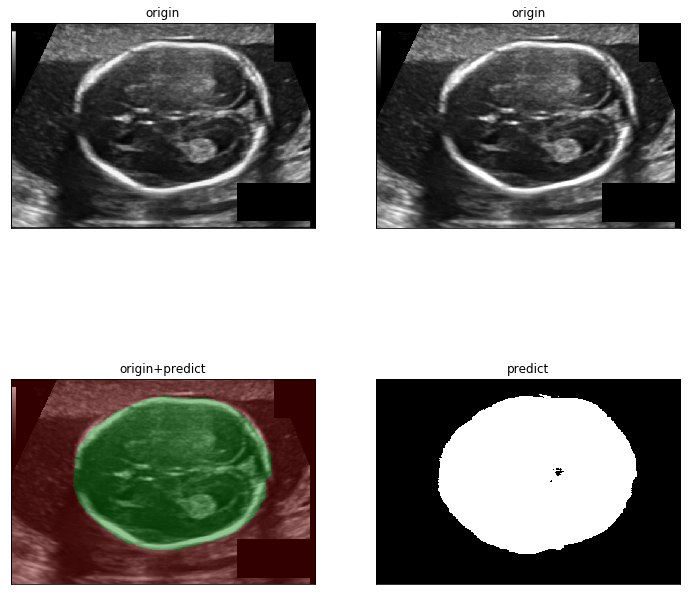

In [ ]:
from paddleseg.models import UNet
import cv2
import paddleseg.transforms as T
import paddle
import numpy as np
import matplotlib.pyplot as plt

transforms = T.Compose([
    # T.Resize(target_size=(512, 512)),
    T.ResizeByLong(512),
    T.Normalize()
])

def predict(model, model_path, im_path):
    para_state_dict = paddle.load(model_path)
    model.set_dict(para_state_dict)
    model.eval()
    im = cv2.imread(im_path)
    im, _ = transforms(im)
    im = im[np.newaxis, ...]
    im = paddle.to_tensor(im)
    output = model(im)[0]
    output = output.numpy()
    output = np.argmax(output,axis=1)
    output = output.transpose(1,2,0)
    return output

im_path = '/home/aistudio/work/test_set/005_HC.png'
vis_path = 'Output3/results/added_prediction/005_HC.png'
label_path = '/home/aistudio/work/test_set/005_HC.png'
model = UNet(num_classes=2)
model_path = '/home/aistudio/Output3/best_model/model.pdparams'

output = predict(model, model_path, im_path)
w,h = output.shape[0], output.shape[1]
segmentation = np.zeros((w,h,1))#用来保存分割结果

image = cv2.imread(im_path)
image, _ = transforms(image)
image = image*0.5 + 0.5
image = np.transpose(image,(1,2,0))
label = cv2.imread(label_path,-1)
output[output == 1] = 127
output[output == 2] = 255

segmentation[:, :, 0] = output[:,:,0] # 保存分割结果
plt.figure(figsize=(12, 12))
segmentation = np.squeeze(segmentation)
plt.subplot(2,2,1),plt.imshow(image,'gray'), plt.title('origin'),plt.xticks([]),plt.yticks([])
plt.subplot(2,2,2),plt.imshow(label,'gray'), plt.title('origin'),plt.xticks([]),plt.yticks([])
plt.subplot(2,2,3),plt.imshow(cv2.imread(vis_path)), plt.title('origin+predict'),plt.xticks([]),plt.yticks([])
plt.subplot(2,2,4),plt.imshow(segmentation,'gray'), plt.title('predict'),plt.xticks([]),plt.yticks([]) 

### 7.后处理
* 保留最大联通区域
* 椭圆拟合
* 伪彩图是4通道（:,:,4）需要改成单通道处理 img[:,:,1]
* 开闭运算
* 

In [ ]:
##生成结果
import os 
import cv2
dist_path = '/home/aistudio/Output3/results/last_processing/Disc_Segmentation'
if not os.path.exists(dist_path):  # 文件夹不存在，则创建
    os.makedirs(dist_path)
result_path = '/home/aistudio/Output3/results/last_processing/pseudo_color_prediction'
for img_name in os.listdir(result_path):
    img_path = os.path.join(result_path, img_name)
    img = cv2.imread(img_path)
    g  = img[:,:,1]
    ret, result = cv2.threshold(g, 127,255, cv2.THRESH_BINARY) ###将伪彩图的像素点设一个阈值生成正常0-255的灰度图
    cv2.imwrite(os.path.join(dist_path,img_name), result)

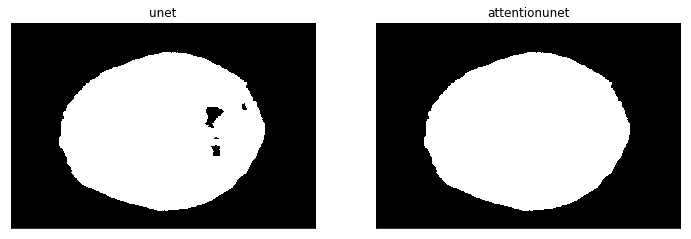

In [ ]:
import numpy as np
import cv2
np.set_printoptions(threshold=np.inf)
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
from skimage import morphology
vis_path = 'Output3/results/last_processing/pseudo_color_prediction/057_HC.png'
img = imread(vis_path)
img  = img[:,:,1]
IMG = morphology.area_opening(img, area_threshold=30000, connectivity=2)
IMG2 = morphology.area_closing(IMG, area_threshold=6400, connectivity=2, parent=None, tree_traverser=None)
cv2.imwrite('mask.png',IMG2)
plt.figure(figsize=(12, 12))
plt.subplot(2,2,1),plt.imshow(img,'gray'), plt.title('unet'),plt.xticks([]),plt.yticks([])
plt.subplot(2,2,2),plt.imshow(IMG2,'gray'), plt.title('attentionunet'),plt.xticks([]),plt.yticks([])
plt.show()
# print(IMG2)


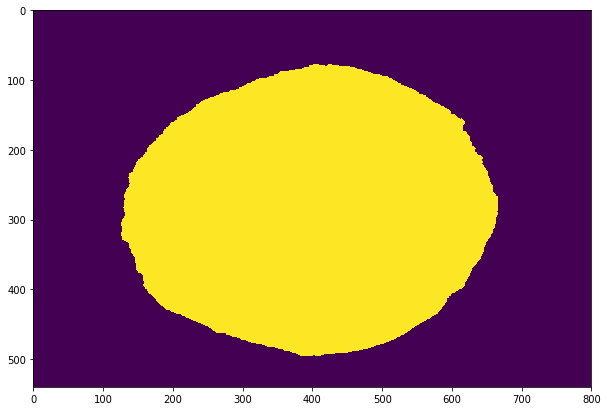

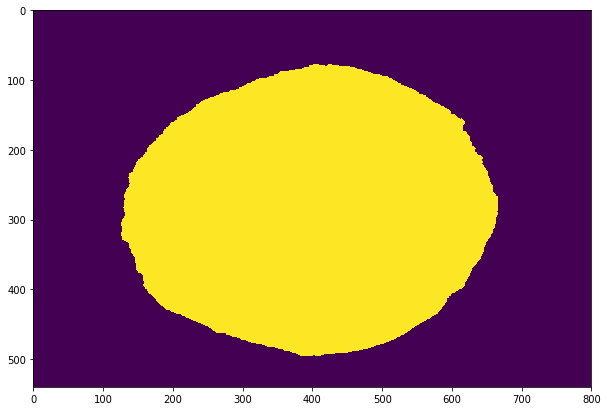

True

In [ ]:
# import os 
# import cv2
# import matplotlib.pyplot as plt
# plt.figure(figsize=(10,10))
# plt.imshow(IMG2)
# plt.show()
# plt.figure(figsize=(10,10))
# g = IMG2[:,:]
# ret, result = cv2.threshold(IMG2, 127,255,cv2.THRESH_BINARY)
# plt.imshow(result)
# plt.show()
# cv2.imwrite('/home/aistudio/1.png',result)
img = imread(vis_path)

In [ ]:
import os 
import cv2
import numpy as np
from PIL import Image
np.set_printoptions(threshold=np.inf)
IMG8 = Image.open('1.png')
IMG8 = np.array(IMG8)
# print(IMG8)
# contours, hierarchy = cv2.findContours(IMG8,cv2.RETR_TREE,\
#                                        cv2.CHAIN_APPROX_NONE) #寻找轮廓
# n=len(contours)       #轮廓个数
# print(n)
# print(len(contours[0]))       #轮廓0像素数目
# area = cv2.contourArea(contours[0])
# print("轮廓的面积：{}".format(area))
# length = cv2.arcLength(contours[0], True)  #获取轮廓长度
# print("轮廓的长度：{}".format(length))
# print(len(img[img==0]))
def B():

    height, width = IMG8.shape
    area =0
    for i in range(height):
        for j in range(width):
            if IMG8[i, j] == 255:
               area += 1
    return print(area)
a = B()
# ellipse = cv2.fitEllipse(contours[0])
# print("ellipse=",ellipse)
# cv2.ellipse(IMG8,ellipse,(0,255,0),3)
# cv2.imshow("result",IMG8)













# contours, hierarchy = cv2.findContours(img,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

# #compute the center of the contour
# M = cv2.moments(contours)
# cX= int(M["m10"] / M["m00"])
# cY= int(M["m01"]/ M["m00"])
# cv2.circle(composite,(cX,cY),7,(255,255,255),-1)


# cv2.imshow("COCO detections", composite)
# cv2.waitKey(0)
# cv2.destroyWindow('COCO detections')


169825


椭圆的中心坐标:(397.711669921875, 287.1716003417969)
 短轴长轴为:(405.6417541503906, 530.439208984375)
 旋转角度为:86.09347534179688

椭圆周长为:1635.7585673332214


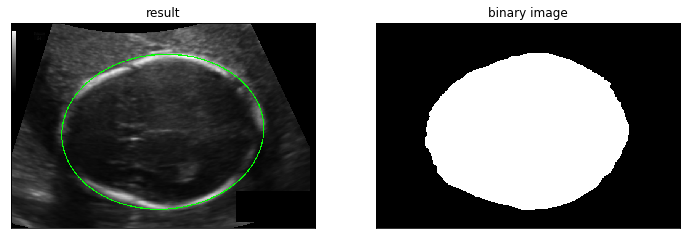

-1

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
ori_im=cv2.imread(r'work/test_set/057_HC.png')
im = cv2.imread(r'1.png')

imgray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
ret,thresh = cv2.threshold(imgray,125,255,cv2.THRESH_BINARY)
# print("ret",ret)
im,contours,hierarchy= cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE) 
# print(len(contours))#轮廓的数量
cnt = contours[0]
cv2.drawContours(im, contours, 0, (0, 0, 255), 2)
ellipse = cv2.fitEllipse(cnt)
# # (x,y),(a,b),angle
perimeter = cv2.arcLength(cnt, True) #参数2：表示轮廓是否封闭
print('椭圆的中心坐标:{}\n'.format(ellipse[0]),'短轴长轴为:{}\n'.format(ellipse[1]),'旋转角度为:{}\n'.format(ellipse[2]) ) #椭圆的中心坐标，短轴长轴(也就是2b,2a)，旋转角度
print('椭圆周长为:{}'.format(perimeter))
cv2.ellipse(ori_im,ellipse,(0,255,0),2)
# def GetArea():
#     height, width = thresh.shape
#     area =0
#     for i in range(height):
#         for j in range(width):
#             if thresh[i, j] == 255:
#                area += 1
#     return print(area)
# a = GetArea()
# #打印椭圆信息((272.5141906738281, 182.0871124267578), (308.0579528808594, 365.59832763671875), 153.9584503173828)
plt.figure(figsize=(12, 12))
plt.subplot(2,2,1),plt.imshow(ori_im), plt.title('result'),plt.xticks([]),plt.yticks([])
plt.subplot(2,2,2),plt.imshow(thresh,'gray'), plt.title('binary image'),plt.xticks([]),plt.yticks([])
plt.show()
cv2.ellipse(ori_im,ellipse,(0,255,0),2)
cv2.imwrite(r'0.png',ori_im)
cv2.waitKey(0)

## ps:有喜欢打比赛的大佬带带我